# **Evaluación del desempeño de modelos de aprendizaje computacional**
---
En este *notebook* se discutirán los distintos métodos y métricas de evaluación del desempeño en modelos de clasificación (binaria y multiclase) y regresión. Además, se discutirá el algoritmo de K-vecinos más cercanos para clasificación y regresión en los conjuntos de datos *Iris* y *Boston*.

# **1. Dependencias**
---
Importamos las librerías necesarias y definimos algunas funciones básicas de visualización que vamos a usar en algunos ejemplos. 


### **1.1. Dependencias**
---
Para la construcción de modelos y ejecución de procedimientos metodológicos de aprendizaje automático, utilizaremos la librería *Scikit-learn* (**`sklearn`**) y varias de sus funciones y conjuntos de datos.

In [3]:
# # Actualizamos scikit-learn a la última versión (de ser necesario)
# !pip install -U scikit-learn

# Instalamos mlxtend una librería de utilidades de aprendizaje computacional
# ! pip install mlxtend

Más información sobre mlxtend en:

+ [mlxtend's documentation](https://rasbt.github.io/mlxtend/)

In [4]:
# # Importamos scikit-learn 
import sklearn

# Librerías básicas de análisis y visualización de datos.
import numpy as np  
import pandas as pd
import matplotlib as mpl        
import matplotlib.pyplot as plt
import seaborn as sns   # Librería de visualización de datos estadísticos.
import mlxtend          # Librería de utilidades de aprendizaje computacional.

In [5]:
# Configuraciones para las librerías y módulos usados

# Ignoramos las advertencias o warnings.
import warnings
warnings.simplefilter(action='ignore')

# Configuramos el formato por defecto de la 
# librería de visualización Matplotlib.
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### **1.2. Funciones de utilidad y visualización**
---

Para ilustrar los ejemplos discutidos en este material utilizaremos algunas funciones que permiten visualizar de manera general los datos y conceptos discutidos en las secciones.

> **Nota**: *Matplotlib*, *Seaborn* y *mlxtend* se encuentran por fuera del alcance de este módulo. No es necesario que entienda estas funciones en detalle para sacar partido del resto del contenido puesto a su disposición. Usted decide si leer o no estas funciones en profundidad. Si decide omitir esta sección, continúe directamente con la siguiente sección, en donde se discutirán los conjuntos de datos que vamos a utilizar.

In [6]:
from mlxtend.plotting import plot_decision_regions

# Función para visualizar la superficie de decisión de un clasificador.
def plot_decision_region(X, y, clf, classes, title = ""):
  fig, ax = plt.subplots(dpi = 120)
  plot_decision_regions(X, y, clf = clf, ax = ax)
  handles, _ = ax.get_legend_handles_labels()
  ax.legend(handles, classes)
  ax.set_title(title)
  fig.show()

In [7]:
def list_confusion_matrix(cm,classes):
  df = pd.DataFrame(data = cm,
                    index = pd.MultiIndex.from_product([['Valor real'], classes]),
                    columns = pd.MultiIndex.from_product([['Valor predicho'], classes]))
  
  return df

# **2. Conjuntos de datos**
---

Como se mencionó, utilizaremos el conjunto de datos *Iris* para los ejemplos de clasificación binaria y clasificación con varias clases y el conjunto de datos *Boston* para los ejemplos de regresión.

### **2.1. Conjunto de datos *Iris***
---
Para el problema de clasificación binaria solo consideraremos $2$ etiquetas y para clasificación con varias clases usaremos las $3$ etiquetas del conjunto de datos *Iris*.En está sección cargaremos el conjunto de datos y haremos una pequeña exploración de datos inicial.

Cargamos *Iris* del paquete **`sklearn.datasets`**:


In [8]:
# Loader del conjunto de datos Iris.
from sklearn import datasets

iris = datasets.load_iris()

Podemos observar que contiene este objeto que nos regresa *Scikit-learn* usando el atributo **`keys()`**:

In [9]:
iris.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])

Con la llave **`DESCR`** podemos acceder a una descripción general del conjunto de datos:

In [10]:
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

Encontramos que el número de muestras y características de **`data`** es:

In [11]:
n_samples, n_features = iris.data.shape

print('Número de muestras:', n_samples)
print('Número de características:', n_features)

Número de muestras: 150
Número de características: 4


Observamos que cada fila corresponde a un ejemplar de una especie de flor. Cada flor tiene asociado una serie de características, como el ancho y largo del sépalo, y el ancho y largo del pétalo.

![](images/iris.png)

In [12]:
for var, value in zip(iris.feature_names, iris.data[-1]):
  print(f"Variable {var}: {value}")

Variable sepal length (cm): 5.9
Variable sepal width (cm): 3.0
Variable petal length (cm): 5.1
Variable petal width (cm): 1.8


Las especies que tratamos de predecir están almacenadas en el atributo **`target_names`**:

In [13]:
print(iris.target_names)

['setosa' 'versicolor' 'virginica']


La distribución de las etiquetas es uniforme en el conjunto de datos, es decir, existe el mismo número (50) de flores por especie en el conjunto de datos:

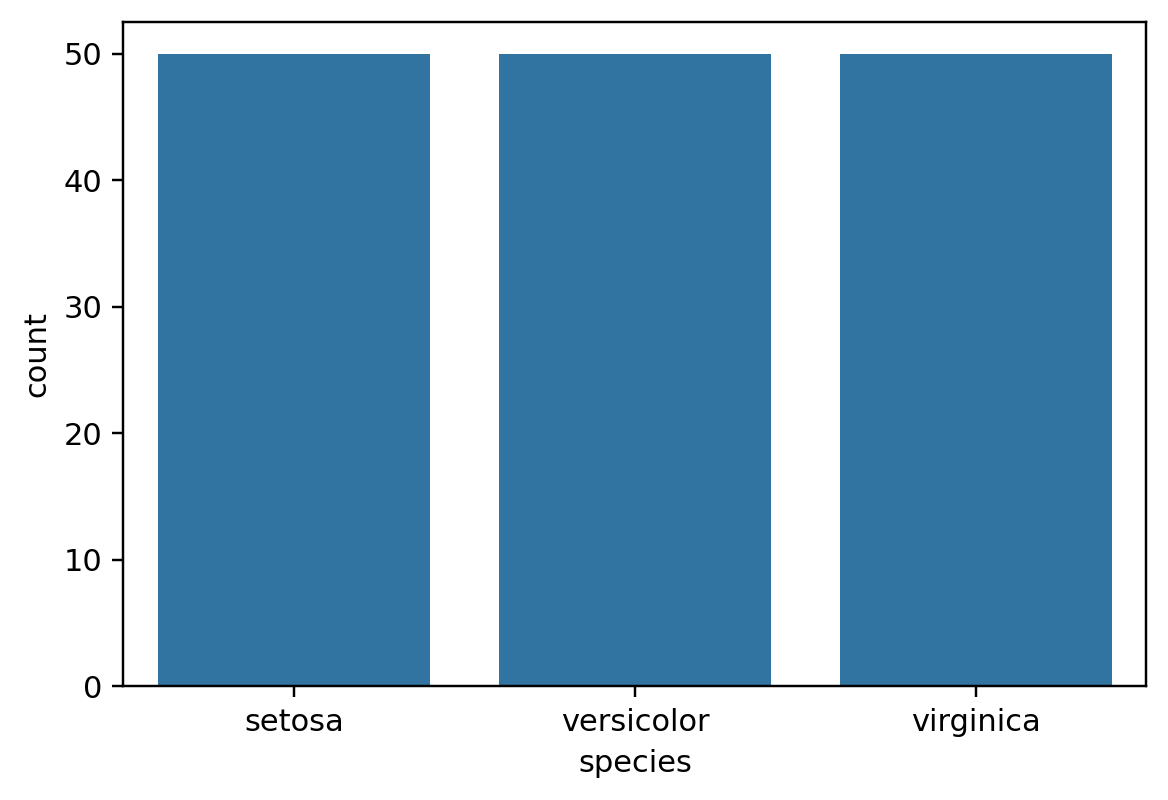

In [14]:
# Cargamos el dataset Iris en forma de DataFrame 
# del repositorio de datos de Seaborn.
iris_df = sns.load_dataset('iris')

# Graficamos la distribución de las etiquetas.
plt.figure(dpi = 110)
sns.countplot(x=iris_df['species']);

Utilizando la función **`pairplot`** de *Seaborn* podemos visualizar todas las características de *Iris*.

> **`pairplot`** nos permite visualizar sobre la diagonal la distribución de las clases respecto a cada característica en forma de histograma y por cada par de características con un diagrama de dispersión. Puede tardar un poco en generar la visualización.

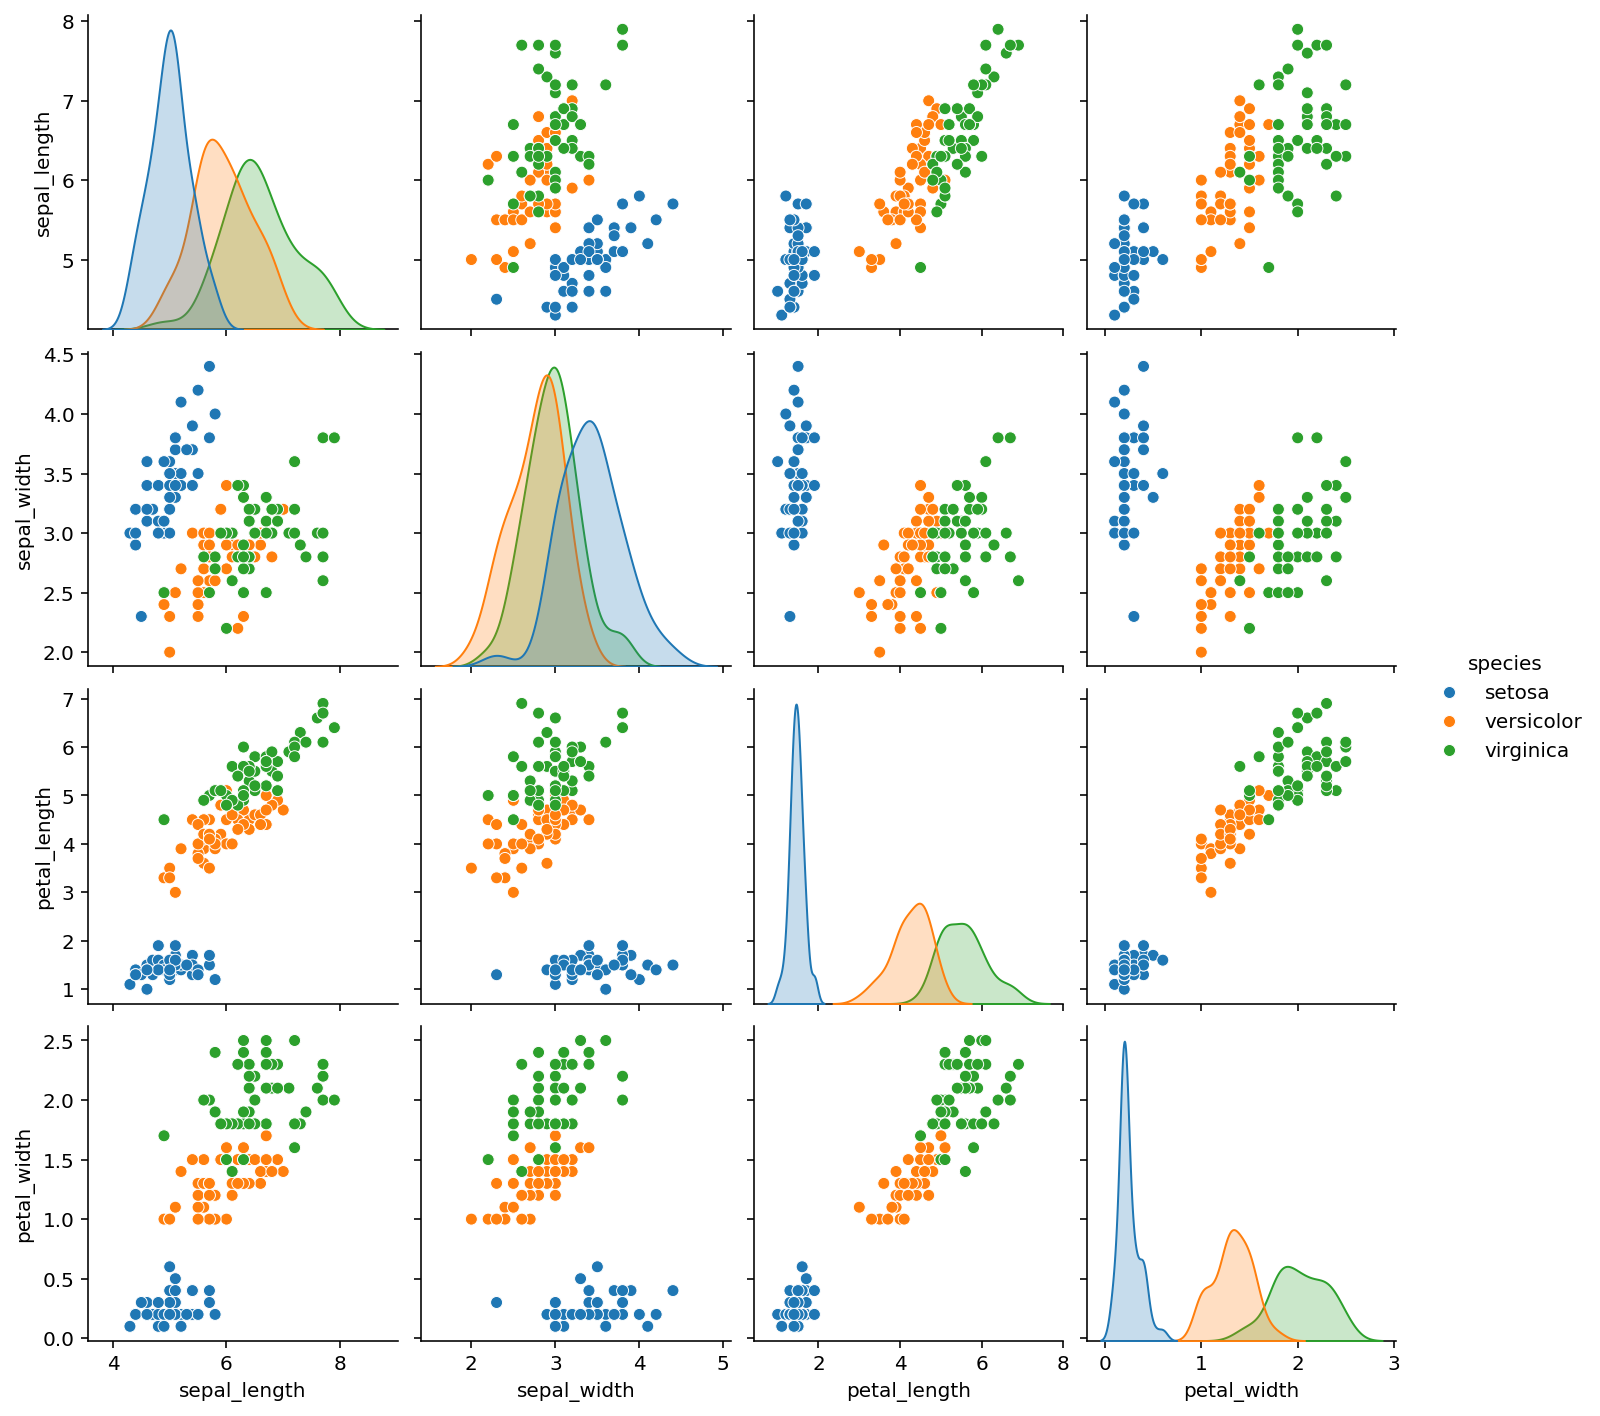

In [15]:
sns.pairplot(iris_df, hue='species');

Podemos observar que en general la clase setosa se encuentra bien separada de las clases versicolor y virginica.

### **2.2 Conjunto de datos _Boston_**
---

Cargamos el conjunto de datos *Boston*:

In [16]:
# Cargar el conjunto de datos Boston (se removio de scikit-learn desde 1.2).
import pickle

# Load data (deserialize)
with open('data/boston.pickle', 'rb') as handle:
    boston = pickle.load(handle)

Revisamos las llaves del diccionario:

In [17]:
print(boston.keys())

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'filename'])


Podemos observar que la llave **`target_names`** está faltando. Esto se debe a que *Boston* es un conjunto de datos que plantea un problema de **regresión** y no existe una distinción por clases de su variable objetivo.

En un problema de regresión la etiqueta asociada a cada ejemplo corresponde a una **cantidad**. Por ejemplo, con el conjunto de datos *Boston* estamos buscando predecir el precio de casas a partir de algunas de sus características.

In [18]:
# Características del dataset Boston.
print(boston['feature_names'])

['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO'
 'B' 'LSTAT']


Para saber mejor a que se refieren las abreviaciones podemos revisar la descripción del conjunto de datos con el atributo **`DESCR`**:

In [19]:
print(boston['DESCR'])

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

Podemos ver que el conjunto de datos tiene características como índices de criminalidad, impuestos, número de cuartos, entre otros, de propiedades en zonas urbanas. La variable objetivo **`target`** corresponde a la variable **`MEDV`**, que representa la mediana del valor de las casas en una zona.

Veamos los primeros $5$ ejemplos:

In [20]:
boston_df = pd.DataFrame(boston.data, columns=boston.feature_names)
boston_df.head(5)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


Nuestro objetivo es centrarnos en la evaluación del desempeño, por lo cual no realizaremos más exploración de los datos. Procederemos directamente con entrenar modelos y evaluar su desempeño.

# **3.  Algoritmo: K-vecinos más cercanos (KNN)**
---

La clasificación basada en vecinos es un tipo de aprendizaje basado en ejemplos. El modelo almacena los ejemplos vistos durante entrenamiento y clasifica un elemento no visto usando una simple regla de votación por mayoría. Si se ubica un **punto** en el espacio de características, se le asigna como clase el valor de la clase que tenga la mayor cantidad de ejemplos en la vecindad del punto. Este ejemplo lo podemos ver ilustrado en la siguiente imagen:

<img src="https://drive.google.com/uc?export=view&id=10I5967XssKpLQLivqER1uwfEw9qIsARd" width=500>

Para ilustrar el concepto utilizaremos el conjunto de datos artificial de medias lunas *moons* de *Scikit-learn*:



In [21]:
# Generamos un conjunto de datos artificial de dos clases en forma de medias lunas.
X_moons, y_moons = datasets.make_moons(n_samples=100, noise=0.3, random_state=0)

*Scikit-Learn* provee una implementación del algoritmo *KNN* conocida como **`KNeighborsClassifier`**. Esta tiene un parámetro **`n_neighbors`** (el valor $k$), un entero definido por el usuario que determina cuántos vecinos evalúa para determinar la clase de una instancia nunca antes vista. La elección de este parámetro es definida totalmente por la naturaleza de los datos.

Vamos a declarar el clasificador y entrenarlo con los datos del conjunto de datos artificial:

In [22]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors= 1)
knn.fit(X_moons, y_moons)

KNeighborsClassifier(n_neighbors=1)

En este caso definimos que $k$ solo tenga en cuenta $1$ vecino más cercano. Si visualizamos la región de decisión podremos observar unas franjas de color azul (clase **A**) en la zona predominantemente naranja (clase **B**), en las cuales el valor más cercano es un único valor de la clase **A** ubicado por aleatoriedad.

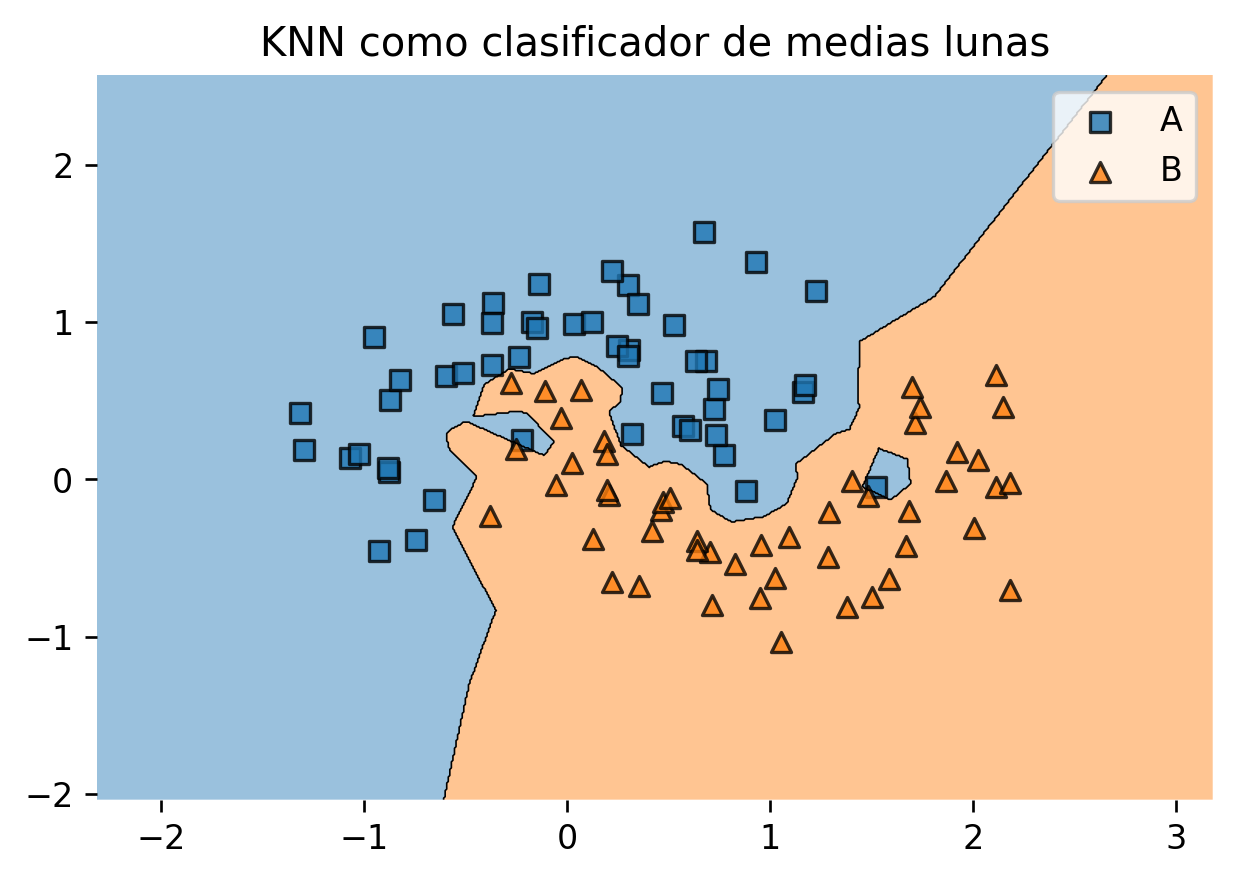

In [23]:
plot_decision_region(X_moons, y_moons, knn, 
                     classes = ['A', 'B'], 
                     title = 'KNN como clasificador de medias lunas')

Observaremos que dependiendo del valor de vecinos más cercanos $k$ que definamos, conseguimos diferentes funciones de ajuste, unas más suaves que otras.

Vamos a evaluar el efecto del parámetro $k$ en la complejidad del modelo. 

# **4. Evaluación del desempeño - Clasificación Binaria**
---

Ahora que conocemos el conjunto de datos *Iris*, queremos entrenar un modelo que sea capaz de clasificar de forma automática cualquier flor representada en un conjunto de datos (a partir del ancho del pétalo (cm), largo del sépalo (cm)', largo del pétalo (cm)' y ancho del pétalo (cm)). 

En **clasificación binaria** se busca identificar la pertenencia de un ejemplo a una clase específica, con un total de $2$ clases en la variable objetivo ($1$ si pertenece y $0$ si no pertenece). 
Para realizar un modelo de este tipo con *Iris* vamos a filtrar aquellas flores que pertenezcan a las clases *versicolor* y *virginica*.

In [25]:
X = iris.data
y = iris.target

# Filtramos la clase 1 y 2 que corresponden a versicolor y virginica.
X = X[(y == 1) | (y == 2)] 
y = y[(y == 1) | (y == 2)] 

# Para que las clases queden entre 0 y 1
# le restamos 1 a todos los valores.
y = y - 1 

In [26]:
X.shape, y.shape

((100, 4), (100,))

Inicialmente, entrenamos el modelo **`KNeighborsClassifier`** con todos los datos y verificamos los valores predichos.

In [27]:
# Módulo de Scikit-learn para modelos lineales.
from sklearn.neighbors import KNeighborsClassifier

# Declaramos y entrenamos el modelo.
classifier = KNeighborsClassifier()
classifier.fit(X, y)
predictions = classifier.predict(X)

n = 30
print(f'Número de instancias a predecir: {n}')
print(f'Valores reales: {y[:n]}')
print(f'Valores predichos: {predictions[:n]}')

Número de instancias a predecir: 30
Valores reales: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valores predichos: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0]


> **Pregunta**: ¿Cómo evaluamos el desempeño de nuestro clasificador?

## **4.1. Error de entrenamiento y generalización**
---

Un modelo de aprendizaje de máquina tiene como objetivo principal hacer predicciones de manera acertada sobre ejemplos nunca antes vistos por el modelo. Esto se conoce como **error de generalización**. Para poder medir el error de generalización, dividimos el conjunto de datos en dos particiones: 

* **Entrenamiento**: Se usa para entrenar el modelo.
* **Prueba**: Se usa para estimar el error de generalización.

En la siguiente imagen encontramos una ilustración de cómo se hace un particionamiento en entrenamiento y prueba de manera gráfica:

<center>
<img src="https://drive.google.com/uc?export=view&id=1wTnv5b52qkLDhgkBgHvA6zs_BEW9a44R">
</center>

Una de las prácticas recomendadas, es particionar los datos $70\%$ para entrenamiento y $30\%$ para prueba. Cuando el número de muestras es muy grande ($\ge 70K$), podemos reducir el porcentaje de muestras para prueba, a $90-10\%$. Sin embargo, deben hacerse unas aclaraciones sobre la generalización:

* **El conjunto de prueba debe ser una muestra representativa del conjunto de datos.** El muestreo de ejemplos debe hacerse de forma independiente e idénticamente aleatoria de una distribución. Esto quiere decir, que el muestreo de un ejemplo no está influenciado por el muestreo de otro.
* **La distribución es estacionaria.** Es decir, no cambia a lo largo del conjunto de datos.
* **Los ejemplos son muestreados desde particiones de la misma distribución.** Es decir, no se deben crear nuevas características en la partición de prueba.

Adicionalmente, debemos tener en cuenta que se conserve la distribución de las etiquetas de los datos tanto en entrenamiento como en prueba (estratificación). 

A continuación, vamos a dividir el conjunto en $70\%$ para entrenamiento y $30\%$ para prueba:

In [28]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                    test_size=0.3,
                                                    stratify=y,
                                                    random_state=42)

El argumento **`stratify`** le indica a *Scikit-learn* que se desea estratificar los datos con respecto a **`y`**.

Vamos a verificar el número de muestras de ambas particiones y la distribución de clases de cada una.

In [29]:
print(f'Número de muestras en entrenamiento: {X_train.shape[0]}')
print(f'Número de muestras en prueba: {X_test.shape[0]}')
print(f'Número de características: {X_train.shape[1]}')

# La función np.bincount permite realizar el conteo 
# de ocurrencia de valores enteros en un arreglo.

print(f'Distribución de clases en entrenamiento: {np.bincount(y_train)}')
print(f'Distribución de clases en prueba: {np.bincount(y_test)}')

Número de muestras en entrenamiento: 70
Número de muestras en prueba: 30
Número de características: 4
Distribución de clases en entrenamiento: [35 35]
Distribución de clases en prueba: [15 15]


Procedemos a entrenar un modelo de clasificación por *K-vecinos* sobre la partición de entrenamiento:

> **Nota**: La partición de prueba está destinada a validar el desempeño del modelo y sus datos no deberían ser vistos por el clasificador.

In [30]:
from sklearn.neighbors import KNeighborsClassifier

classifier = KNeighborsClassifier(n_neighbors=5)
classifier.fit(X_train, y_train)

KNeighborsClassifier()

## **4.2. Exactitud o *accuracy***
---
Con el objetivo de conocer el desempeño de nuestro clasificador se suele medir cuantitativamente cuantas predicciones fueron correctas. Este número se conoce como **exactitud** o **_accuracy_** en inglés y es la métrica por defecto en muchos de los modelos de clasificación de *Scikit-learn*.

In [32]:
prediction = classifier.predict(X_test)

# Número de valores acertados de una predicción.
np.mean(prediction == y_test)

0.8666666666666667

*Scikit-learn* nos permite evaluar también el accuracy con la función **`.score`** de un clasificador:

In [33]:
classifier.score(X_test, y_test)

0.8666666666666667

También se puede realizar de forma explícita mediante la función **`accuracy_score`** del módulo **`sklearn.metrics`**.

In [34]:
from sklearn.metrics import accuracy_score

y_pred = classifier.predict(X_test)
accuracy_score(y_test, y_pred)

0.8666666666666667

## **4.3. Matriz de confusión**
---

No obstante, es importante conocer qué clases clasifica mejor. Para poder visualizar esta información, usaremos la **matriz de confusión**, la cual es una clase especial de tabla de contingencia en la cual se comparan las clases reales contra las clases predichas por el clasificador. 

**Scikit-Learn** nos permite construir la matriz de confusión usando la función **`sklearn.metrics.confusion_matrix`**, que recibe como argumento dos listas o arreglos de *NumPy*:
* $y$: etiquetas reales del conjunto de datos.
* $\hat{y}$: etiquetas predichas por el clasificador sobre el conjunto de datos.

In [35]:
from sklearn.metrics import confusion_matrix

y_pred = classifier.predict(X_test)
cnf_matrix = confusion_matrix(y_test, y_pred)

La función **`confusion_matrix`** regresa una matriz de tamaño $\textit{n\_clases} \times \textit{n\_clases}$, dónde $\textit{n\_clases}$ corresponde al número de clases únicas en el conjunto de datos. La matriz de confusión nos permite comparar el rendimiento de nuestro clasificador clase por clase.

In [37]:
cnf_matrix

array([[12,  3],
       [ 1, 14]])

A continuación, vamos a usar la función definida al comienzo de este *notebook* para generar de una forma más visual la matriz de confusión.

In [41]:
class_names = iris.target_names[1:]
list_confusion_matrix(cnf_matrix, class_names)

Valor predicho          
                          versicolor virginica
Valor real versicolor             12         3
           virginica               1        14

> **¿Cómo interpretarla?**

* Los valores en la diagonal indican los aciertos de nuestro clasificador. Por ejemplo, sabemos que de $15$ ejemplos de la clase *virginica*, supo clasificar $14$, mientras que de $15$ ejemplos de la clase *versicolor* se equivocó en $3$.

> **¿Qué pasa cuando el problema es desbalanceado?**

Supongamos un clasificador $G$ con el siguiente desempeño sobre un conjunto de datos:

* $\text{Accuracy} = \frac{99}{100} = 99\%$  
* $\text{Error} = \frac{1}{100} = 1\%$  

> **¿Es un buen clasificador?**

Para medir efectivamente si $G$ es un buen clasificador, presentamos la matriz de confusión producto de sus predicciones.

In [42]:
# Clases de ejemplo.
class_names = ['C_+', 'C_-']

# Valores reales y predichos de ejemplo.
y_pred_G = np.ones(100)
y_test_G = np.ones(100)
y_test_G[-1] = 0

mat = confusion_matrix(y_test_G, y_pred_G)
list_confusion_matrix(mat, class_names)

Valor predicho    
                          C_+ C_-
Valor real C_+              0   1
           C_-              0  99

A pesar de que el modelo clasificó correctamente $99$ muestras de la clase negativa, falló en clasificar la única muestra positiva del conjunto de datos.

## **4.4. Métricas de precisión, *Recall* y F1**
---

La matriz de confusión nos permite calcular otra serie de medidas para evaluar el desempeño del clasificador. Para introducir estas medidas, vamos a descomponer la matriz de confusión en cuatro partes:

<img src="images/confmatrix.png" width=700>


Los componentes de esta matriz pueden interpretarse como:
* **Verdaderos positivos (VP)**. Resultado correcto para la clase positiva.
* **Verdaderos negativos (VN)**. Ausencia correcta para la clase positiva.
* **Falsos positivos (FP)**. Resultados inesperados.
* **Falsos negativos (FN)**. Resultados faltantes.

> **Nota**: Vale la pena aclarar que, en clasificación binaria, los términos *positivo* o *negativo* se refieren a la predicción del clasificador (clase), mientras que *verdadero* o *falso* se refieren a si la predicción fue correcta o no.

De esta matriz podemos volver a escribir las definiciones de *accuracy* y error:

* $\text{accuracy} = \frac{\text{VP} + \text{VN}}{\text{VP} + \text{VN} + \text{VP} + \text{VN}}$

* $\text{error} = \frac{\text{FP} + \text{FN}}{\text{VP} + \text{VN} + \text{VP} + \text{VN}}$  

Además de estas, podemos definir las siguientes métricas:

* **Precisión**: se puede definir como la habilidad del clasificador de **no** clasificar una muestra como positiva cuando es negativa. 

  > $\text{PRE} = \frac{\text{VP}}{\text{VP} + \text{FP}}$ 


* ***Recall* (índice de recuperación)**:  se puede definir como la capacidad del clasificador de encontrar todas las muestras positivas. 
  > $\text{REC} = \frac{\text{TP}}{\text{FN} + \text{TP}}$ 

* **$F_1$ score**: se define como el promedio ponderado entre la precisión y el *recall*. 

  >$\text{F}_1 = 2 * \frac{\text{PRE}*\text{REC}}{\text{PRE} + \text{REC}}$

Evaluemos la precisión y el índice de recuperación de nuestro clasificador $G$:

* $\text{Precision} = \frac{0}{0}$ = No definida
* $\text{Recall} = \frac{0}{1} = 0\%$ Recall

*Scikit-learn* provee diferentes funciones para calcular estas tres medidas. Estas son:

* **Precisión: `sklearn.metrics.precision_score`**
* **_Recall_: `sklearn.metrics.recall_score`**
* **$F_1$ score: `sklearn.metrics.f1_score`**


Vamos a medir el desempeño sobre el clasificador $G$:

In [45]:
from sklearn import metrics

print(f'Precisión: {metrics.precision_score(y_test_G, y_pred_G, pos_label=0)}')
print(f'Recall:    {metrics.recall_score(y_test_G, y_pred_G, pos_label=0)}')
print(f'F_1 score: {metrics.f1_score(y_test_G, y_pred_G, pos_label=0)}')

Precisión: 0.0
Recall:    0.0
F_1 score: 0.0


> El argumento **`pos_label`** indica cual etiqueta corresponde a la clase positiva. Para nuestro ejemplo hemos tomado la clase $0$ como la clase positiva. Por otro lado, *Scikit-learn* le asigna el valor $0$ a estas métricas, aunque no estén bien definidas (por ejemplo si el denominador es 0).


Regresando al problema de clasificación sobre *Iris*, podemos calcular el valor de la precisión, _recall_ y $F_1$ de la misma manera:

In [46]:
print(f'Precisión: {metrics.precision_score(y_test, prediction):.4f}')
print(f'Recall:    {metrics.recall_score(y_test, prediction):.4f}')
print(f'F_1 score: {metrics.f1_score(y_test, prediction):.4f}')

Precisión: 0.8235
Recall:    0.9333
F_1 score: 0.8750


# **5. Evaluación del desempeño - Clasificación Multiclase**
---
Esta vez usaremos todos los ejemplos de cada una de las tres especies de flor del *dataset Iris*. Para obtener una representación gráfica, nos limitaremos a dos variables numéricas de entrada (longitud del sépalo en $x$ y longitud del pétalo en $y$).

Primero que todo realizamos la partición de los datos en entrenamiento y prueba:

In [47]:
# Esta vez usamos las 3 clases y solo 2 variables.

X = iris.data[:,[0, 2]] 
y = iris.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    stratify=y, random_state=31)

In [48]:
print('El shape de X_train es:', X_train.shape)
print('El shape de y_train es:', y_train.shape)

print('El shape de X_test es:', X_test.shape)
print('El shape de y_test es:', y_test.shape)

El shape de X_train es: (105, 2)
El shape de y_train es: (105,)
El shape de X_test es: (45, 2)
El shape de y_test es: (45,)


Entrenaremos dos modelos *KNN* **`clf_k1`** y **`clf_k5`**, donde **`clf_k5`** usará los $5$ vecinos más cercanos y **`clf_k1`** solo el más cercano.

Definimos el clasificador **`clf_k1`** y lo entrenamos:

In [49]:
# Clasificador KNN con k = 1.
clf_k1 = KNeighborsClassifier(n_neighbors=1)
clf_k1.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=1)

Definimos el clasificador **`clf_k5`** y lo entrenamos:

In [52]:
# Clasificador KNN con k = 5.
clf_k5 = KNeighborsClassifier(n_neighbors=5)
clf_k5.fit(X_train, y_train)

KNeighborsClassifier()

A continuación, visualizamos las regiones de decisión para cada clasificador:

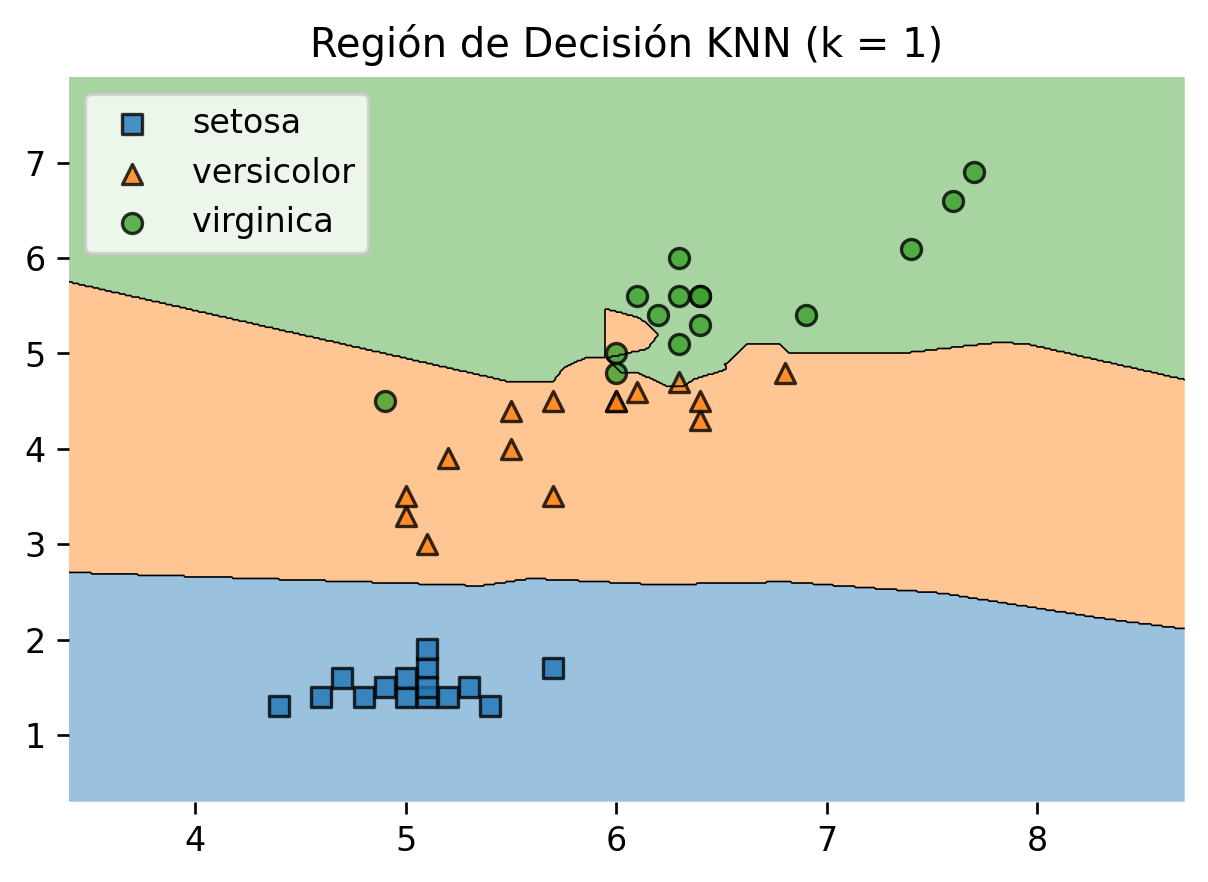

In [53]:
plot_decision_region(X_test, y_test, clf_k1, iris.target_names,
                title = 'Región de Decisión KNN (k = 1)')

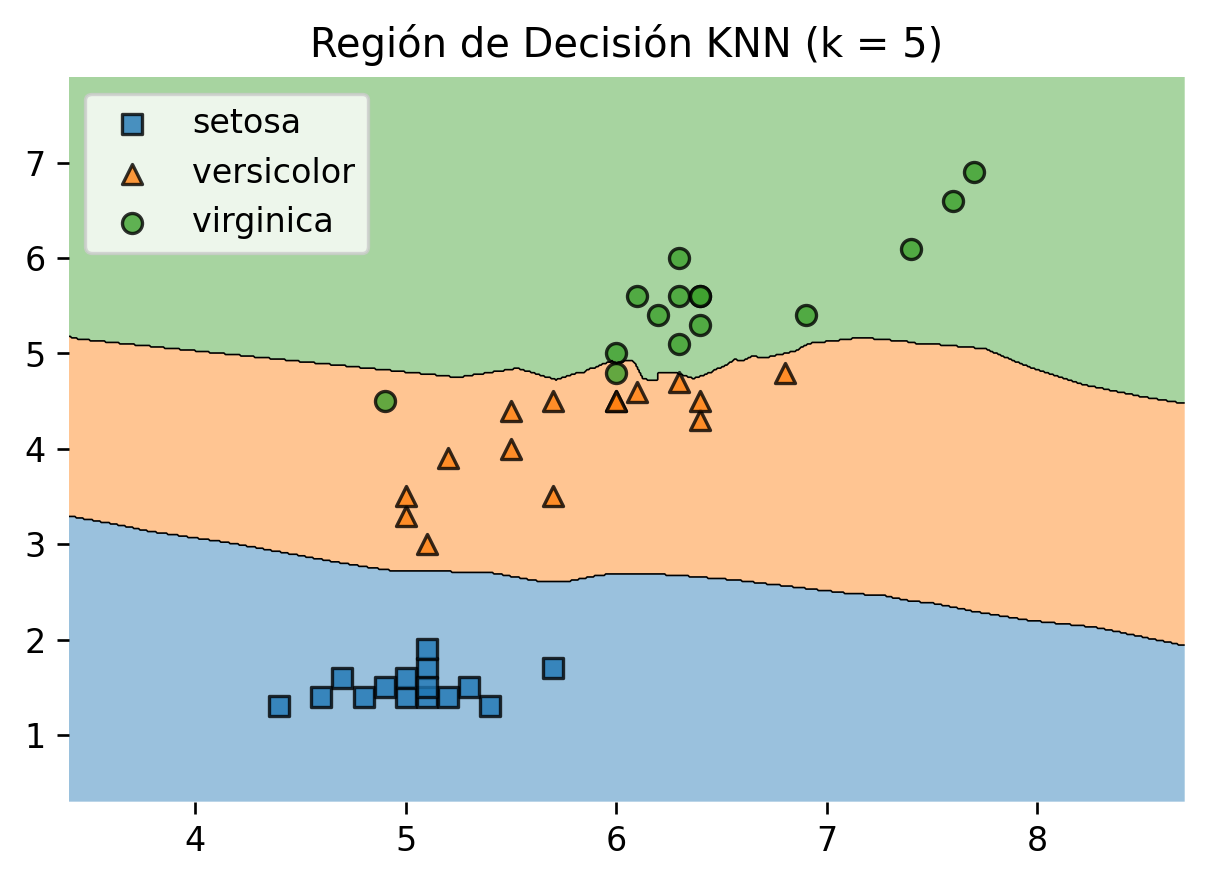

In [54]:
plot_decision_region(X_test, y_test, clf_k5, iris.target_names,
                title = 'Región de Decisión KNN (k = 5)')

Podemos notar que a medida que **`n_neighbors`** es mayor, la región de decisión es más suave. En el caso de **`n_neighbors = 1`**, el modelo se está ajustando a las particularidades de la partición de entrenamiento.

### **5.1. Matriz de confusión con más de 2 clases**
---

La matriz de confusión se puede extender al problema multiclase de la siguiente manera:



Primero, visualizaremos la matriz de confusión para el modelo *KNN* con **`n_neighbors=1`**:

In [55]:
y_pred = clf_k1.predict(X_test)        

# Generamos y mostramos la matriz de confusión.
mat = confusion_matrix(y_test, y_pred)  
list_confusion_matrix(mat, iris.target_names) 

Valor predicho                     
                              setosa versicolor virginica
Valor real setosa                 15          0         0
           versicolor              0         14         1
           virginica               0          3        12

Ahora calculamos la matriz de confusión para el modelo con **`n_neighbors=5`**:

In [56]:
y_pred = clf_k5.predict(X_test)

# Generamos y mostramos la matriz de confusión.
mat = confusion_matrix(y_test, y_pred)
list_confusion_matrix(mat, iris.target_names)

Valor predicho                     
                              setosa versicolor virginica
Valor real setosa                 15          0         0
           versicolor              0         15         0
           virginica               0          2        13

A simple vista podemos identificar que:
* La clase *setosa* es fácil de clasificar para ambos clasificadores.
* La clase *virginica* es más difícil de clasificar que la clase *versicolor*, pues con **`n_neighbors=5`** el modelo obtiene puntaje perfecto para *versicolor* pero sigue fallando con $2$ ejemplos de *virginica*.

De nuevo, es útil usar una medida de desempeño para comparar cuantitativamente el rendimiento de ambos modelos.

### **5.2. *Accuracy* multiclase**
---

El *accuracy* multiclase se define como la fracción de predicciones correctas del clasificador. Se puede calcular con la siguiente fórmula:

$$
\texttt{acc}(y, \hat{y}) = \frac{1}{n} \sum_{i=0}^{n-1} 1(\hat{y}_i = y_i)
$$

dónde $y$ corresponde a la lista de etiquetas de verdad de nuestro conjunto de datos, mientras $\hat{y}$ corresponde a los valores predichos por nuestro clasificador para el mismo conjunto de datos **en el mismo orden**, y $n$ corresponde al número de ejemplos del conjunto. 

*Scikit-Learn* nos permite calcular el *accuracy* de la misma manera que con un modelo de clasificación binaria:

In [58]:
print(f'Accuracy n_neighbors = 1: {clf_k1.score(X_test, y_test):.4f}')
print(f'Accuracy n_neighbors = 5: {clf_k5.score(X_test, y_test):.4f}')

Accuracy n_neighbors = 1: 0.9111
Accuracy n_neighbors = 5: 0.9556


El modelo de regresión logística se desempeña mejor frente al modelo "*Uno vs Todos*". El error se puede definir como la fracción de predicciones incorrectas del clasificador:

In [59]:
print(f'Error n_neighbors = 1: {1 - clf_k1.score(X_test, y_test):.4f}')
print(f'Error n_neighbors = 5: {1 - clf_k5.score(X_test, y_test):.4f}')

Error n_neighbors = 1: 0.0889
Error n_neighbors = 5: 0.0444


### **5.3. Precisión, *recall* y $F_1$ *score* en clasificación multiclase**
---

La métrica de precisión era calculada con base a la matriz de confusión del problema de clasificación binaria. De igual manera, se puede extender como medida de desempeño para el problema multiclase de varias formas. Recordemos que:

* $\text{Precisión} = \frac{\text{VP}}{\text{VP} + \text{FP}}$ 
* $\text{Recall} = \frac{\text{VP}}{\text{VP} + \text{FN}}$ 
* $F_1 = 2 * \frac{\text{PRE}*\text{REC}}{\text{PRE} + \text{REC}}$

Para ilustrar como se calcula cada una de estas medidas, usaremos el clasificador con **`n_neighbors=1`**. 

Primero calculamos la precisión para cada clase y luego determinamos la forma en la que combinamos las precisiones de cada clase. *Scikit-Learn* nos permite calcular la precisión y *recall* por clase así:

* **Nota**: Al definir el argumento **`average = None`** se le indica al cálculo de la métrica que se retorne el valor de la métrica por cada clase, en vez de realizar una agregación general para todo el conjunto de datos.

In [63]:
from sklearn.metrics import precision_score, recall_score

## Usando clf_k1
y_pred = clf_k1.predict(X_test)

print(f'Orden de las etiquetas: {iris.target_names}')
print(f'Precisión por clase: \t{precision_score(y_test, y_pred, average=None)}')
print(f'Recall por clase: \t{recall_score(y_test, y_pred, average=None)}')

Orden de las etiquetas: ['setosa' 'versicolor' 'virginica']
Precisión por clase: 	[1.         0.82352941 0.92307692]
Recall por clase: 	[1.         0.93333333 0.8       ]


Añadimos un par de cálculos a nuestra tabla con la matriz de confusión, donde reflejamos la suma de los valores totales de verdaderos positivos, falsos positivos y falsos negativos. Existen varias formas de combinar o agregar las medidas de precisión y *recall* por clase, que son definidas a partir del argumento **`average`** de las métricas mencionadas. Algunos de los posibles valores son:
* **`micro`** : Cuenta el total de positivos verdaderos, falsos positivos y falsos negativos para realizar el cálculo de la métrica.
* **`macro`** : Calcula la métrica por cada clase y luego la promedia (sin tener en cuenta el balance de clases).
* **`weighted`** : Calcula la precisión por clase y luego la promedia teniendo en cuenta el balance de clases.

| Clase    | VP   | FP   | FN   | PRE  | REC  |
|----------|------|------|------|------|------|
|Setosa    | 15   | 0    | 0    | 1.0  | 1.0  |
|          |      |      |      |      |      |
|Versicolor| 14   | 3    | 1    | 0.824 | 0.933  |
|          |      |      |      |      |      |
|Virginica | 12   | 1    | 3    | 0.923 | 0.800 |
|          |      |      |      |      |      |
|Sum(micro)| 41  | 4   | 4   | 0.911 | 0.911 |
|          |      |      |      |      |      |
|Avg(macro)|      |      |      | 0.916 | 0.911 |


In [65]:
print(f"Precisión macro: {precision_score(y_test, y_pred, average='macro'):.4f}")
print(f"Precisión micro: {precision_score(y_test, y_pred, average='micro'):.4f}")
print(f"Precisión ponderada: {precision_score(y_test, y_pred, average='weighted'):.4f}\n")

print(f"Recall macro: {recall_score(y_test, y_pred, average='macro'):.4f}")
print(f"Recall micro: {recall_score(y_test, y_pred, average='micro'):.4f}")
print(f"Recall ponderada: {recall_score(y_test, y_pred, average='weighted'):.4f}")

Precisión macro: 0.9155
Precisión micro: 0.9111
Precisión ponderada: 0.9155

Recall macro: 0.9111
Recall micro: 0.9111
Recall ponderada: 0.9111


Como observamos, estos valores corresponden a las dos últimas filas que se calcularon sobre la tabla de precisión y *recall*. Vale la pena anotar que **`weighted`** y **`macro`** son iguales cuando la clase es balanceada, tal como en el ejemplo de *Iris*. Esto se puede extender al cálculo del $F_1 \textit{score}$. Recordemos que el $F_1 \textit{score}$  es un promedio ponderado de la precisión y el *recall*.

In [66]:
from sklearn.metrics import f1_score

print(f"F1 macro: {f1_score(y_test, y_pred, average='macro'):.4f}")
print(f"F1 micro: {f1_score(y_test, y_pred, average='micro'):.4f}")
print(f"F1 ponderada: {f1_score(y_test, y_pred, average='weighted'):.4f}")

F1 macro: 0.9107
F1 micro: 0.9111
F1 ponderada: 0.9107


Para finalizar, *Scikit-Learn* permite realizar un reporte general con todas las métricas mencionadas con la función **`classification_report`** del módulo **`sklearn.metrics`**:

In [67]:
from sklearn.metrics import classification_report

print(classification_report(y_test,    
                            y_pred,                                
                            target_names=iris.target_names,  
                            digits=4))

              precision    recall  f1-score   support

      setosa     1.0000    1.0000    1.0000        15
  versicolor     0.8235    0.9333    0.8750        15
   virginica     0.9231    0.8000    0.8571        15

    accuracy                         0.9111        45
   macro avg     0.9155    0.9111    0.9107        45
weighted avg     0.9155    0.9111    0.9107        45



Utilizamos el parámetro **`digits`** para indicar cuantos dígitos reportar y **`target_names`** para indicarle a **`classification_report`** los nombres de las clases.

# **6. Evaluación del desempeño - Regresión**
---

En esta sección veremos la evaluación del desempeño para modelos de regresión, usando el conjunto de datos *Boston*. Como es usual, primero realizamos una partición de entrenamiento y prueba tomando el $30\%$ para prueba.

> **Nota**: Tenga en cuenta que no realizamos estratificación debido a que se trata de un problema de regresión.

Importaremos y particionaremos los datos del conjunto de datos de *Boston*:


In [74]:
X, y = boston.data, boston.target

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    random_state=12, test_size=0.3)

### **6.1. KNN como regresor**
---

El algoritmo *KNN* también es aplicable en problemas de regresión. La clase **`KNeighborsRegressor`** de *Scikit-learn* aplica una interpolación local de la etiqueta de los $n$ vecinos más cercanos para realizar la predicción.

Por defecto, **`KNeighborsRegressor`** toma el promedio de la etiqueta de los vecinos. Sin embargo, también se puede tomar un promedio ponderado por el inverso de la distancia especificando el parámetro **`weights = 'distance'`**.

Entrenaremos un modelo *KNN* con $5$ vecinos para regresión:

In [75]:
from sklearn.neighbors import KNeighborsRegressor

model = KNeighborsRegressor(n_neighbors=5, 
                            weights='distance')

model.fit(X_train, y_train)

KNeighborsRegressor(weights='distance')

Si usamos el método **`score`** del modelo nos retornará la métrica conocida como el **coeficiente de determinación**, y no la exactitud del modelo. En un problema de regresión no tiene sentido hablar de exactitud u otras métricas cómo la precisión o el *recall*.

In [76]:
model.score(X_test, y_test)

0.4743034798512158

Antes de explorar el concepto del coeficiente de determinación primero introduciremos las métricas de **error cuadrático medio (MSE)** y de la **raíz del error cuadrático medio (RMSE)**.

### **6.2. Error cuadrático medio (_MSE, Mean-Squared-Error_)**
---

El error cuadrático medio se define como:

$$\text{MSE} = \frac{1}{n}\sum_{i=0}^{n}(\hat{y}_i - y_i)^2$$

Donde:

* $y\,- \text{Etiqueta Real}$
* $\hat{y}\,- \text{Predicción}$

El _MSE_ toma la diferencia entre la etiqueta y la predicción (error) por cada ejemplo, las eleva al cuadrado y las suma y las divide sobre el total de ejemplos. En otras palabras, el _MSE_ es la media del error al cuadrado $(\hat{y}_i - y_i)^2$. Note que por definición el _MSE_ solo toma valores mayores o iguales a $0$.

Tomar el cuadrado de los errores permite evaluar diferencias positivas tanto negativas de la misma manera. Tenga en cuenta que esto también implica que el orden de $\hat{y}_i$ y $y_i$ no es relevante para el cálculo del error.

Tomar el cuadrado también penaliza los errores más grandes. Un _MSE_ pequeño índica que, en promedio, los errores para todos los ejemplos son pequeños. Otra manera de interpretar el _MSE_ es como la varianza de los errores (que tan dispersos son). El _MSE_ tiene muchas interpretaciones estadísticas importantes, como la descomposición en varianza y sesgo, las cuales no están dentro del alcance de este curso.


En *Scikit-learn*, el _MSE_ puede ser calculado con el método **`mean_squared_error`** de la siguiente manera:

In [77]:
from sklearn.metrics import mean_squared_error

y_pred = model.predict(X_test)

mean_squared_error(y_test, y_pred)

46.11812861720047

### **6.3. Raíz del error cuadrático medio (_RMSE, Root-Mean-Squared-Error_)**
---

La raíz del error cuadrático medio se define como:

$$\text{RMSE} = \sqrt{\frac{1}{n}\sum_{i=0}^{n}(\hat{y}_i - y_i)^2}$$

Donde:

* $y\,- \text{Etiqueta Real}$
* $\hat{y}\,- \text{Predicción}$

Aunque sea simplemente la raíz del _MSE_, el _RMSE_ tiene la ventaja de ser interpretable en las unidades originales del problema.

EL _RMSE_ puede ser calculado de la siguiente manera:

In [79]:
np.sqrt(mean_squared_error(y_test, y_pred))

6.791032956568571

### **6.4. Coeficiente de Determinación ($\text{R}^2$)**
---

El coeficiente de determinación (o $R$ cuadrado) se define como:

$$\text{R}^2 = 1 - \frac{\frac{1}{n}\sum_{i=0}^{n}(\hat{y}_i - y_i)^2}{\frac{1}{n}\sum_{i=0}^{n}(y_i - \bar{y})^2}$$

Donde:

* $y\,- \text{Etiqueta Real}$

* $\hat{y}\,- \text{Predicción}$

* $\bar{y}\,- \text{Media de y:}\, \frac{1}{n}\sum_{i=0}^{n}y_i^2$

Podemos notar que el numerador de la división corresponde al error cuadrático medio (varianza de los errores) y que el denominador de la división corresponde a la varianza de las etiquetas.

La varianza de las etiquetas está escrita de una manera muy similar al _MSE_, de hecho, si definiéramos un modelo que para un conjunto de ejemplos prediga para cada uno de los ejemplos la media de sus etiquetas (llamémoslo modelo de la media) y calculáramos su _MSE_ sería exactamente esta varianza.

El modelo de la media es lo que se considera como un *baseline*. Los *baseline* o modelos de línea base son modelos sencillos usados para comparar su desempeño contra modelos más complejos.

Dicho lo anterior, si definimos el _MSE_ del modelo de la media como $\text{MMSE}$ (Mean Model Squared Error) entonces $\text{R}^2$  puede ser escrito de la siguiente manera:

$$\text{R}^2 = 1 - \frac{\text{MSE}}{\text{MMSE}} = \frac{\text{MMSE} - \text{MSE}}{\text{MMSE}}$$

De esta manera, podemos interpretar el coeficiente de determinación como una proporción de mejora en la predicción de un modelo comparado con el modelo de la media de las etiquetas. El mejor valor de $\text{R}^2$  es $1$ y también puede tomar valores negativos (para modelos mucho peores). También cabe notar que el coeficiente de determinación es dependiente del conjunto de datos, y por lo tanto no es comparable entre distintos conjuntos de datos.

Se dice que el coeficiente representa la proporción de la varianza (de _y_) que ha sido explicada por las variables independientes en el modelo. Indica que tan bien serán predichos ejemplos nunca antes vistos por el modelo, a través de la proporción de esa varianza explicada.



El coeficiente de determinación puede ser calculado a través de la función **`score`** de los modelos de regresión. Sin embargo, también se puede calcular a través del método **`r2_score`** de **`sklearn.metrics`**:

In [81]:
from sklearn.metrics import r2_score

y_pred = model.predict(X_test)

print(f'Coeficiente de Determinación usando score:, {model.score(X_test, y_test):.4f}')
print(f'Coeficiente de Determinación con r2_score:, {r2_score(y_test, y_pred):.4f}')

Coeficiente de Determinación usando score:, 0.4743
Coeficiente de Determinación con r2_score:, 0.4743


De esta manera podemos determinar que el modelo representa una mejora sobre el modelo de las medias. Sin embargo, aún puede mejorarse el desempeño.

# **Recursos adicionales**
---
Los siguientes enlaces corresponden a sitios en donde encontrará información muy útil para profundizar en el conocimiento de las funcionalidades de la librería *Scikit-learn* para la evaluación del desempeño de sus modelos, además de material de apoyo teórico para reforzar estos conceptos:

- [scikit-learn - Model Evaluation](https://scikit-learn.org/stable/modules/model_evaluation.html)
- [Metrics to understand regression model](https://towardsdatascience.com/metrics-to-understand-regression-models-in-plain-english-part-1-c902b2f4156f)
- [Difference Between Classification and Regression in Machine Learning](https://machinelearningmastery.com/classification-versus-regression-in-machine-learning/)



